<a href="https://colab.research.google.com/github/idnm/grand_unification_demo/blob/main/grand_unification_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grand unification of quantum algorithms
> Or quantum singular value transformation, if you do not feel grandiose

In [ ]:
try:
    import pyqsp
except ImportError:
    !pip install pyqsp

from functools import reduce    
    
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

import pyqsp
import pyqsp.angle_sequence
import pyqsp.response

from tqdm.auto import tqdm

# What is this all about?

Quantum singular value transformation (QSVT) is a modern framework that can express in a unified way many of the prominent quantum algorithms. The basic idea is that given a linear map $H$ it is often possible to prepare a quantum circuit that performs a polynomial transformation on the singular values of $H$. For instance, Hamiltonian simulation, i.e. construction of the evolution operator $e^{-iHt}$, is equivalent to transforming the eigenvalues $\lambda_i$ of $H$ to $\lambda_i\to e^{-i\lambda_i t}$. Solving a linear system with matrix $H$ is equivalent to inverting its singular values $\lambda_i\to \lambda^{-1}_i$. Performing Grover's search is equivalent to amplifying a single matrix element (the overlap between the initial and the target state), i.e. the singular value of a $1\times1$ matrix, and also falls within this framework. 

There are several essential ingredients necessary to implement this program.
- Quantum signal processing (QSP), which can be thought of as the special case for $1\times1$ operators $H$ embedded in a two-dimensional space, the state space of a single qubit.
- Qubitization, which is a way of applying single-qubit QSP to multi-dimensional problems.
- $\dots$

Loose ends
- How to perform polynomial approximation
- How to do block encoding
- How to turn matrix operations into quantum circuits

# Quantum signal processing: basic example

I don't really know what the quantum signal processing (QSP) is about, and there are probably many ways to introduce it. Here we will take a simple-minded approach that aligns well with what will follow after QSP. Suppose you have a qubit and can apply to it a $Z$ rotation $Z(\phi):=e^{i\phi Z}$. If you started in the computational basis state, $Z(\phi)$ won't do anything. Now suppose you also can perform some fixed unitary operator $W$. The precise definition of $W$ probably does not matter much, but it is common to assume that $W$ is an $X$-rotation at some fixed angle $\theta$
$$
W=X(\theta):=e^{i\theta X}=\begin{pmatrix}a& i\sqrt{1-a^2}\\ i\sqrt{1-a^2} & a\end{pmatrix}
$$
here $a=\cos\theta$. In QSP, $W$ is called the signal operator and $Z(\phi)$ is called the signal-processing operator. Using both, we can construct quite general single-qubit operations (probably universal?).

Here is a standard illustration. The probability of of the qubit to remain in state $|0\rangle$ after applying $W$ is
$$
|\langle0|W_x(\theta)|0\rangle|^2=\cos^2 \theta
$$
Using the signal processing, we can tweak this transition probability. The processed signal is defined by
$$
U_{\pmb\phi}=Z(\phi_0)\prod_k W Z(\phi_k)
$$
and specified by giving $k+1$ angles $\pmb\phi=(\phi_0,\dots,\phi_k)$. For instance, setting $\pmb\phi=(\pi/2, -\eta, 2\eta, 0, -2\eta,\eta)$ with $\eta=\frac12 \arccos(-\frac14)$ suppressed transitions in a wider range around $\theta=0$(the first and the last angles do not matter?). Here is an implementation.

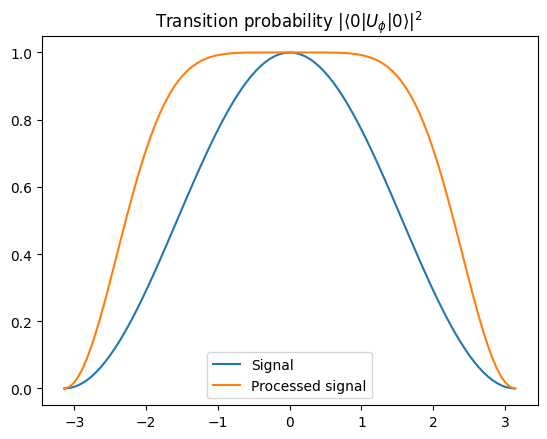

In [ ]:
def X(theta):
    return np.array([
        [np.cos(theta), 1j*np.sin(theta)], 
        [1j*np.sin(theta), np.cos(theta)]
    ])

def Z(phi):
    return np.array([
        [np.exp(1j*phi), 0], 
        [0, np.exp(-1j*phi)]
    ])

def U_QSP(W, phi):
    operators = [Z(phi[0])]
    for p in phi[1:]:
        operators.append(W)
        operators.append(Z(p))
    return reduce(np.matmul, operators)

theta = np.linspace(-np.pi, np.pi, 100)
eta = np.arccos(-1/4)/2
# phi = np.array([np.pi/2,-eta,2*eta, 0, -2*eta, eta])
phi = np.array([0, -eta, 2*eta, 0, -2*eta, 0])

plt.plot(theta, [np.abs(X(t/2)[0, 0])**2 for t in theta], label='Signal');
plt.plot(theta, [np.abs(U_QSP(X(t/2), phi)[0, 0])**2 for t in theta], label='Processed signal');
plt.title(r'Transition probability $|\langle 0|U_{\phi}|0\rangle|^2$ ')
plt.legend();

More generally, QSP allows to perform a polynomial tranformation on matrix elements of $W$, explicitly
$$
U_{\pmb\phi}=\begin{pmatrix}P(a)&iQ(a)\sqrt{1-a^2}\\iQ^*(a)\sqrt{1-a^2}&P^*(a)\end{pmatrix}
$$
In fact, any degree $d$ polynomial $P(a)$ can be obtained in this way subject to the constraints
- constraints on $P$ and $Q$
- $\dots$

This reduces the task of signal processing to constructing a polynomial with the desired properties in the relevant parameter range.

# Amplitude amplification

Now let's extend QSP beyond the single-qubit problems. The simplest example of this kind is the task of the amplitude amplification. Here is the deal. Suppose we have an initial state $|B_0\rangle$ and want to map it to some target state $|A_0\rangle$. However, we can only perform some "signal" unitary operator $W$, which has small but non-zero transition amplitude $\langle A_0|W|B_0\rangle$. Obviously, just using $W$ can not be sufficient in general. Assume also that we can implement $A_\phi=e^{i\phi |A_0\rangle\langle A_0|}$ and $B_\phi=e^{i\phi |B_0\rangle\langle B_0|}$ as well. These operators are analogs of the $Z$-rotation "signal processing" operator. It turns out to be possible to build a circuit $U$ out of $W, W^\dagger, A_\phi, B_\phi$ that will feature a large transition amplitude $\langle A_0|U|B_0\rangle$. Interestingly, no specific knowledge of $U$ is assumed, even the amplitude $\langle A_0|W|B_0\rangle$ needs not be known. For this reason this is called an oblivious amplitude amplification. If you think that the problem is artificial please bear with us until we relate it, without much changes, to Grover's search. 

The task looks similar to what can be solved with a QSP, but here our states and operators can belong to a high-dimensional space. To apply QSP we first need to reduce the problem to a two-dimensional one, or to "qubitize" it. 
To this end, denote by $\mathcal{H}_A$ the 2d vector space spanned by $|A_0\rangle$ and $W|B_0\rangle$. These vectors are not orthogonal by assumption, and it will be convenient to introduce $|A_1\rangle$ that also lives in $\mathcal{H}_A$ and *is* orthogonal to $|A_0\rangle$. We can define $|A_1\rangle$ by
$$
W|B_0\rangle=a|A_0\rangle+i\sqrt{1-a^2}|A_1\rangle
$$
i.e. we split the image of $|B_0\rangle$ into a component along $|A_0\rangle$ and an orthogonal one, which we call $|A_1\rangle$. We assume that parameter $a$ is real, a possible phase can be absorbed into $|A_1\rangle$. The operator $W^\dagger$ maps $\mathcal{H}_A$ to another 2d subspace which we call $\mathcal{H}_B$. It is spanned by $|B_0\rangle$ and another vector $|B_1\rangle$, which can be defined to satisfy
$$
W|B_1\rangle=i\sqrt{1-a^2}|A_0\rangle+a|A_1\rangle
$$
In the bases chosen, restriction of $W$ mapping $\mathcal{H}_B\to \mathcal{H}_A$ has the following matrix form
$$
W|_{BA}=\begin{pmatrix}a&i\sqrt{1-a^2}\\i\sqrt{1-a^2}&a\end{pmatrix}=X(\theta)
$$
where $a=\cos\theta$. Similarly, one shows that
$$
W^\dagger|_{AB}=X(-\theta)=Z X(\theta) Z,\qquad A_\phi|_{AA}=B_\phi|_{BB}\simeq Z(\phi/2)
$$
Here and in the following $\simeq$ means equality up to a global phase, which often can be ignored.
OK, so recall we have our amplitude $\langle A_0|W|B_0\rangle$, how to amplify it? We will apply QSP in the space $\mathcal{H}_A$. For that, we will need an operator mapping $\mathcal{H}_A$ to itself. Here is how such an operator can be constructed
$$
U(\phi_1,\phi_2) = W B_{\phi_1} W^\dagger A_{\phi_2}
$$
Its non-trivial matrix elements can be computed as
$$
U(\phi_1,\phi_2)|_{AA}= W|_{AB} B_{\phi_1}|_{BB} W^\dagger|_{BA} A_{\phi_2}|_{AA}\simeq X(\theta) Z(\frac{\phi_1+\pi}{2}) X(\theta) Z(\frac{\phi_2+\pi}2)
$$
Applying $U(\phi_1,\phi_2)$ multiple times generates exactly the signal processing transformation we saw before. Note that the angles $\phi$ must be adjusted to comply with the QSP notation, $\phi\to 2\phi-\pi$.

Now that we can perform polynomial transformations on the original amplitude, how exactly do we amplify it, what kind of polynomial does that? Turns out, we one can cook a decent polynomial approximation to $sign$ function. Here is how it looks.

[pyqsp.poly.PolySign] degree=15, delta=10
[PolyTaylorSeries] max [0.89938904] is at [0.99190301]: normalizing
[PolyTaylorSeries] average error = 0.11235939233759482 in the domain [-1, 1] using degree 15


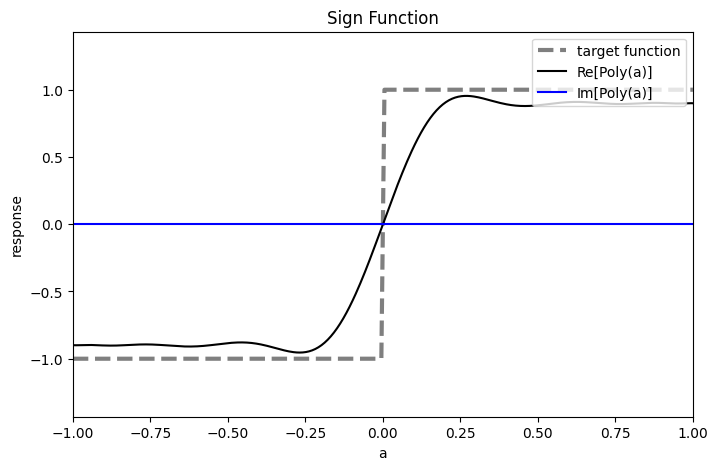

In [ ]:
def get_amplitude_amplification_angles(degree):
    pg = pyqsp.poly.PolySign()
    pcoefs, scale = pg.generate(degree, delta=10, ensure_bounded=True, return_scale=True)
    phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(pcoefs, signal_operator='Wx')
    return np.array(phis)

degree = 15
pyqsp.response.PlotQSPResponse(
    get_amplitude_amplification_angles(degree),
    target=lambda x: np.sign(x),
    signal_operator='Wx',
    title="Sign Function")

OK, with all the ingredients in place we can now code our basic implementation of the amplitude amplification.

In [ ]:
# Define rotation unitaries and the amplitude amplification circuit.

def rotation(A, phi):
    # Implements e^{i phi |A><A|}
    n = len(A)
    return np.identity(n)+(np.exp(1j * phi)-1)*np.outer(A, A.conj())

def U_amplitude_amplification(A, B, W, phi):
    assert len(phi) % 2 == 0, 'Amplitude amplification requires an odd number of angles'
    
    operators = [rotation(A, phi[0])]
    
    for phi_B, phi_A in phi[1:-1].reshape(-1, 2):
        operators.append(W)
        operators.append(rotation(B, phi_B))
        operators.append(W.conj().T)
        operators.append(rotation(A, phi_A))
    
    operators.append(W)
    operators.append(rotation(B, phi[-1]))

    return reduce(np.matmul, operators)

Now we define a bunch of random vectors $|A\rangle, |B\rangle$, random signals $W$ and apply test amplitude amplification algorithm for several different approximation polynomials.

In [ ]:
np.random.seed(0)

# The full Hilbert space is not 2d!
num_qubits = 4
num_samples = 100
degrees = (5, 9, 15)

phis = [get_amplitude_amplification_angles(d) for d in degrees]

original_amplitudes = np.zeros(num_samples)
amplified_amplitudes = np.zeros((len(degrees), num_samples))


for i in tqdm(range(num_samples)):
    
    # Random signal operator
    W = unitary_group.rvs(2**num_qubits, random_state=i)
    
    # A random state can be defined as a row of a random unitary
    A = unitary_group.rvs(2**num_qubits, random_state=i+num_samples)[0]
    B = unitary_group.rvs(2**num_qubits, random_state=i+2*num_samples)[0]
    
    original_amplitude = np.abs(A.conj()@W@B)
    amplified_amplitudes_slice = []
    for phi in phis:
        phi = 2*phi-np.pi # Remember to adjust the angles!
        U = U_amplitude_amplification(A, B, W, phi)
        amplified_amplitude = np.abs(A.conj()@U@B)
        amplified_amplitudes_slice.append(amplified_amplitude)
    
    original_amplitudes[i] = original_amplitude
    amplified_amplitudes[:, i] = np.array(amplified_amplitudes_slice)

[pyqsp.poly.PolySign] degree=5, delta=10
[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.21930741075851684 in the domain [-1, 1] using degree 5
[pyqsp.poly.PolySign] degree=9, delta=10
[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.15018408679233242 in the domain [-1, 1] using degree 9
[pyqsp.poly.PolySign] degree=15, delta=10
[PolyTaylorSeries] max [0.89938904] is at [0.99190301]: normalizing
[PolyTaylorSeries] average error = 0.11235939233759482 in the domain [-1, 1] using degree 15


  0%|          | 0/100 [00:00<?, ?it/s]

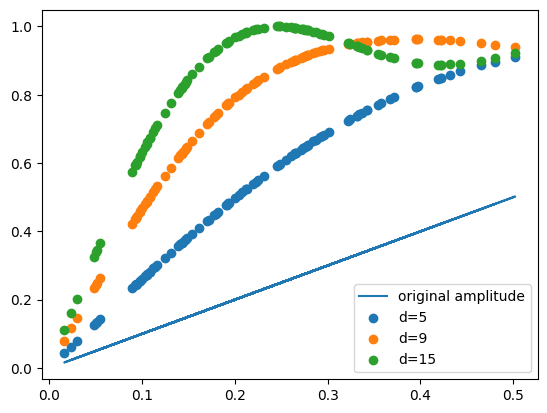

In [ ]:
plt.plot(original_amplitudes, original_amplitudes, label='original amplitude')
for d, amplitudes in zip(degrees, amplified_amplitudes):
    plt.scatter(original_amplitudes, amplitudes, label=f'd={d}')
plt.legend();

OK, this looks reasonable!

# Unstructured search

The celebrated Grover's search solves the following problem. Provided access to operator $A_{\pi}=1-2|A_0\rangle\langle A_0|$ find $|A_0\rangle$, which is assumed to be a computational basis state. This is similar to the amplitude amplification. We can choose the signal operator as $W=H^n$, the Hadamard on all the qubits and $|B_0\rangle=|0\rangle^n$, the all zero state. There are two main differences with the oblivious amplitude amplification
1. We can only use $A_\pi$ and not arbitrary rotations $A_\phi$.
1. The initial amplitude $\langle A_0|W|B_0\rangle=\frac{1}{\sqrt{N}}$ is known.
Using 1. and the fact that $A_\pi|_{A}=\simeq Z$ leads to
$$
U(\phi)=W B_{\phi} W^\dagger A_{\pi}\simeq X(\theta) Z(\frac{\phi+\pi}{2}) X(\theta)
$$
Therefore, the operator being processed is $X(2\theta)$ rather than $X(\theta)$. Indeed
$$
U_{\pmb\phi}|_{AB}= \left(\prod_k U(\phi_k)\right)|_{AA}W|_{AB}=X(\theta) \prod_k Z(\frac{\phi_k+\pi}{2}) X(2\theta)
$$
We can rewrite this as
$$
U_{\pmb\phi}|_{AB}=X(-\theta)\prod_{k>1} X(2\theta) Z(\frac{\phi_k+\pi}{2})
$$
So it seems that the goal is to choose the signal processing that will transform $X(2\theta)\to X(\theta)$, so that $U_{\pmb\phi}\to 1$. Since $\cos2\theta=2\cos^2\theta-1$ in terms of the polynomial transformation this means finding $P$ such that $P(2a^2-1)\approx a$. Note that this only need to hold for $a=1/\sqrt{N}$.

In [ ]:
H = 1/np.sqrt(2)*np.array([
    [1, 1],
    [1, -1]
])

def hadamard(num_qubits):
    return reduce(np.kron, [H]*num_qubits)

def U_Grover(num_qubits, reps):
    Hn = hadamard(num_qubits)
    
    operators = [H]
    for r in range(reps):
        operators()

In [ ]:
np.random.seed(42)

num_qubits = 4

# |B> = |0>
B = np.zeros(2**num_qubits)
B[0] = 1

# |A> = |n> with random n
A = np.zeros(2**num_qubits)
A[np.random.randint(0, 2**num_qubits)] = 1